Fit LN filters starting with matched two-exponential MA fit, then adjusting to better capture offset responses.

Note: must be run after MA fit

In [1]:
%matplotlib inline
from copy import deepcopy as copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import optimize, signal, stats
import sys

from aux import load_npy
from disp import set_plot
from record_2_lin_ln import smlt_lnma_tweaked

cc = np.concatenate

FPS = 30.03
DT = 1/FPS

DUR_H = 10
IDUR_H = int(round(DUR_H/DT))

NNRN = 224
ALPHA = 0

FMA = 'data/simple/neur/baker_ma.npy'
FSAVE = 'data/simple/neur/baker_lnma_tweaked.npy'

In [2]:
# load data
DF_S = pd.read_csv('data/simple/neur/baker_resampled_s.csv')
DF_P = pd.read_csv('data/simple/neur/baker_resampled_p.csv')

I_S = np.array(DF_S['S'])
I_P = np.array(DF_P['P'])

R_SS = np.array(DF_S[[f'R_{cnrn}' for cnrn in range(NNRN)]])
R_PS = np.array(DF_P[[f'R_{cnrn}' for cnrn in range(NNRN)]])

T = np.arange(len(I_S))*DT

In [3]:
nrns_fit = np.arange(NNRN)
# nrns_fit = [64, 65, 66, 74, 78, 79, 85, 141, 142, 143, 144, 145, 176, 177, 180, 204, 205, 206, 207, 208]
# nrns_fit = [64, 65]

Load MA params

In [4]:
params_ma = load_npy(FMA)
tau_rs_ma = params_ma['TAU_R']
tau_as_ma = params_ma['TAU_A']
x_ss_ma = params_ma['X_S']
x_ps_ma = params_ma['X_P']

x_s_0_0s = np.nan*np.zeros(NNRN)
tau_s_0_0s = np.nan*np.zeros(NNRN)
x_s_1_0s = np.nan*np.zeros(NNRN)
tau_s_1_0s = np.nan*np.zeros(NNRN)

x_p_0_0s = np.nan*np.zeros(NNRN)
tau_p_0_0s = np.nan*np.zeros(NNRN)
x_p_1_0s = np.nan*np.zeros(NNRN)
tau_p_1_0s = np.nan*np.zeros(NNRN)

sgn_0s = np.zeros(NNRN)

for cnrn, (tau_r, tau_a, x_s, x_p) in enumerate(zip(tau_rs_ma, tau_as_ma, x_ss_ma, x_ps_ma)):
    gam = (1/tau_a) - (1/tau_r)
    
    x_s_0 = (x_s/(tau_r/tau_a - 1))*(-1/tau_r)
    tau_s_0 = tau_r
    x_s_1 = (x_s/(tau_r/tau_a - 1))*(1/tau_a)
    tau_s_1 = tau_a

    x_p_0 = (x_p/(tau_r/tau_a - 1))*(-1/tau_r)
    tau_p_0 = tau_r
    x_p_1 = (x_p/(tau_r/tau_a - 1))*(1/tau_a)
    tau_p_1 = tau_a
        
    # store derived two-exp params
    x_s_0_0s[cnrn] = x_s_0
    tau_s_0_0s[cnrn] = tau_s_0
    x_s_1_0s[cnrn] = x_s_1
    tau_s_1_0s[cnrn] = tau_s_1
    
    x_p_0_0s[cnrn] = x_p_0
    tau_p_0_0s[cnrn] = tau_p_0
    x_p_1_0s[cnrn] = x_p_1
    tau_p_1_0s[cnrn] = tau_p_1
    
    sgn_0s[cnrn] = np.sign(np.mean([x_s, x_p]))
    
params_0 = {
    'X_S_0': x_s_0_0s, 'TAU_S_0': tau_s_0_0s, 'X_S_1': x_s_1_0s, 'TAU_S_1': tau_s_1_0s,
    'X_P_0': x_p_0_0s, 'TAU_P_0': tau_p_0_0s, 'X_P_1': x_p_1_0s, 'TAU_P_1': tau_p_1_0s,
    'SGN': sgn_0s
}

# Examine pre-fit responses

In [5]:
r_smln_s_0s = smlt_lnma_tweaked(I_S, 0*I_P, params_0, DT)
r_smln_p_0s = smlt_lnma_tweaked(0*I_S, I_P, params_0, DT)

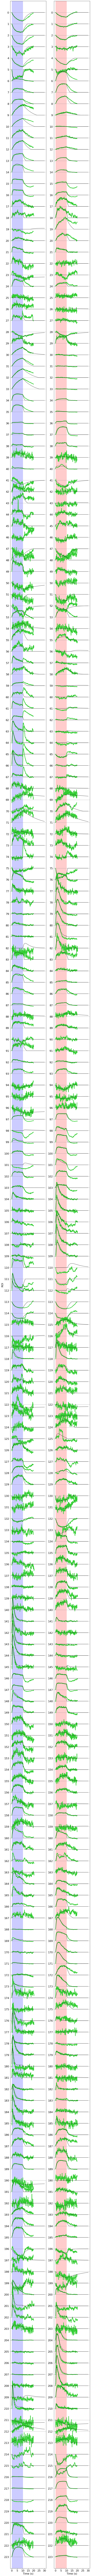

In [6]:
nplot = len(nrns_fit)
t = np.arange(len(R_SS))*DT

fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated 
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', lw=1)  # simulated
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 4), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

# Adjust timescales, etc

In [7]:
# set of neurons to ignore sine-offset response in fitting
ignore_off_s = [57, 60, 61, 62, 63, 64, 65, 66, 67, 74, 98, 101, 110, 146, 147, 162]
ignore_off_p = [62, 65, 67, 74, 98, 146, 147]

In [8]:
# objective function for ln2e fit
def obj(param, r_s, r_p, sgn):
    x_s_0, tau_s_0, x_s_1, tau_s_1 = param[:4]
    x_p_0, tau_p_0, x_p_1, tau_p_1 = param[4:]
    
    params_temp = {
        'X_S_0': np.array([x_s_0]), 'TAU_S_0': np.array([tau_s_0]),
        'X_S_1': np.array([x_s_1]), 'TAU_S_1': np.array([tau_s_1]),
        'X_P_0': np.array([x_p_0]), 'TAU_P_0': np.array([tau_p_0]),
        'X_P_1': np.array([x_p_1]), 'TAU_P_1': np.array([tau_p_1]),
        'SGN': np.array(sgn),
    }
    
    r_smln_s = smlt_lnma_tweaked(I_S, 0*I_P, params_temp, DT)[:, 0]
    r_smln_p = smlt_lnma_tweaked(0*I_S, I_P, params_temp, DT)[:, 0]
    
    # compute error
    mse = np.nanmean(cc([r_s-r_smln_s, r_p-r_smln_p])**2)
    return mse

bounds = 4*[(None, None), (.001, 120)]

In [9]:
# loop over nrns
x_s_0_1s = np.nan*np.zeros(NNRN)
tau_s_0_1s = np.nan*np.zeros(NNRN)
x_s_1_1s = np.nan*np.zeros(NNRN)
tau_s_1_1s = np.nan*np.zeros(NNRN)

x_p_0_1s = np.nan*np.zeros(NNRN)
tau_p_0_1s = np.nan*np.zeros(NNRN)
x_p_1_1s = np.nan*np.zeros(NNRN)
tau_p_1_1s = np.nan*np.zeros(NNRN)

sgn_1s = sgn_0s.copy()

for cnrn, inrn in enumerate(nrns_fit):
    sys.stdout.write('.')
    r_s = R_SS[:, inrn].copy()
    r_p = R_PS[:, inrn].copy()
    
    if inrn in ignore_off_s:
        r_s[T >= 10] = np.nan
    if inrn in ignore_off_p:
        r_p[T >= 10] = np.nan
        
    x_0 = [
        x_s_0_0s[inrn], tau_s_0_0s[inrn], x_s_1_0s[inrn], tau_s_1_0s[inrn],
        x_p_0_0s[inrn], tau_p_0_0s[inrn], x_p_1_0s[inrn], tau_p_1_0s[inrn]
    ]
    
    # fit model
    np.random.seed(0)
    fit_rslt = optimize.minimize(obj, x_0, args=(r_s, r_p, sgn_0s[inrn]), bounds=bounds)
    
    # unpack params
    x_s_0, tau_s_0, x_s_1, tau_s_1 = fit_rslt.x[:4]
    x_p_0, tau_p_0, x_p_1, tau_p_1 = fit_rslt.x[4:]
    
    x_s_0_1s[inrn] = x_s_0
    tau_s_0_1s[inrn] = tau_s_0
    x_s_1_1s[inrn] = x_s_1
    tau_s_1_1s[inrn] = tau_s_1
    
    x_p_0_1s[inrn] = x_p_0
    tau_p_0_1s[inrn] = tau_p_0
    x_p_1_1s[inrn] = x_p_1
    tau_p_1_1s[inrn] = tau_p_1
    

................................................................................................................................................................................................................................

In [10]:
params_1 = {
    'EXPT_ID': np.arange(NNRN),
    'X_S_0': x_s_0_1s, 'TAU_S_0': tau_s_0_1s, 
    'X_S_1': x_s_1_1s, 'TAU_S_1': tau_s_1_1s, 
    'X_P_0': x_p_0_1s, 'TAU_P_0': tau_p_0_1s, 
    'X_P_1': x_p_1_1s, 'TAU_P_1': tau_p_1_1s, 
    'SGN': sgn_1s,
}

# Examine Step-1 responses

In [11]:
r_smln_s_1s = smlt_lnma_tweaked(I_S, 0*I_P, params_1, DT)
r_smln_p_1s = smlt_lnma_tweaked(0*I_S, I_P, params_1, DT)

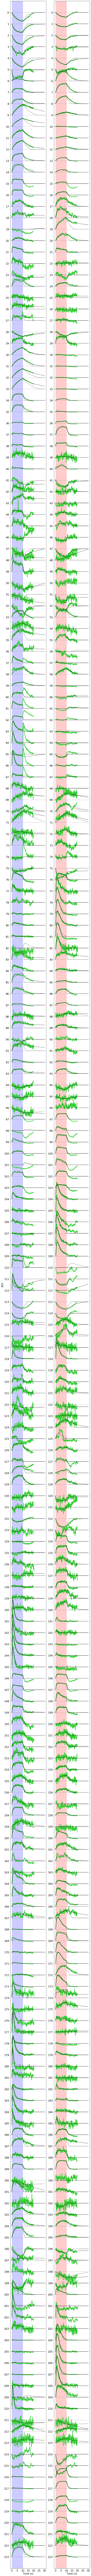

In [12]:
nplot = len(nrns_fit)
t = np.arange(len(R_SS))*DT

fig, axs = plt.subplots(1, 2, figsize=(8, nplot), tight_layout=True)
y_ticks = []

for cnrn, inrn in enumerate(nrns_fit):
    y_tick = -4*cnrn
    
    ## sine response
    axs[0].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[0].plot(t, R_SS[:, inrn] + y_tick, c='limegreen', lw=3)  # true
    axs[0].plot(t, r_smln_s_0s[:, inrn] + y_tick, c='k', lw=1, ls='--')  # simulated 
    axs[0].plot(t, r_smln_s_1s[:, inrn] + y_tick, c='k', lw=1)  # simulated 
    
    ## pulse response
    axs[1].axhline(y_tick, lw=1, ls='--', c='gray')
    axs[1].plot(t, R_PS[:, inrn] + y_tick, c='limegreen', lw=3)
    axs[1].plot(t, r_smln_p_0s[:, inrn] + y_tick, c='k', lw=1, ls='--')  # simulated
    axs[1].plot(t, r_smln_p_1s[:, inrn] + y_tick, c='k', lw=1)  # simulated
    
    y_ticks.append(y_tick)
    
axs[0].axvspan(0, 10, color='b', alpha=.2)
axs[1].axvspan(0, 10, color='r', alpha=.2)

axs[0].set_ylabel('ROI')

for ax in axs:
    set_plot(ax, y_lim=(-4*nplot, 4), y_ticks=y_ticks, y_tick_labels=nrns_fit, x_label='Time (s)', font_size=16)

In [13]:
np.save(FSAVE, np.array([params_1]))